**Loading the Data**

In [156]:
import pandas as pd

df = pd.read_csv("DSNY_Monthly_Tonnage_Data_20250413.csv")

In [157]:
df.head()

,MONTH,BOROUGH,COMMUNITYDISTRICT,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED,RESORGANICSTONS,SCHOOLORGANICTONS,LEAVESORGANICTONS,XMASTREETONS,BOROUGH_ID
0,2024 / 01,Manhattan,05,1261.7,270.8,166.7,NaN,NaN,NaN,12.6,1.0
1,2023 / 07,Queens,07,6821.7,735.8,757.8,101.5,NaN,NaN,NaN,4.0
2,2023 / 12,Bronx,10,2603.9,353.3,348.8,NaN,NaN,8.6,NaN,2.0
3,2024 / 01,Bronx,05,3389.6,223.2,334.1,NaN,74.9,NaN,3.8,2.0
4,2024 / 03,Brooklyn,17,3985.8,281.7,387.4,51.8,NaN,NaN,NaN,3.0


In [158]:
print(df.shape)

(24299, 11)


In [159]:
print(df.duplicated().sum())

0


In [160]:
print(df.describe)

<bound method NDFrame.describe of            MONTH    BOROUGH COMMUNITYDISTRICT  REFUSETONSCOLLECTED  \
0      2024 / 01  Manhattan                05               1261.7   
1      2023 / 07     Queens                07               6821.7   
2      2023 / 12      Bronx                10               2603.9   
3      2024 / 01      Bronx                05               3389.6   
4      2024 / 03   Brooklyn                17               3985.8   
...          ...        ...               ...                  ...   
24294  2025 / 04      Bronx                04                984.1   
24295  2025 / 04      Bronx                09                856.1   
24296  2025 / 04   Brooklyn                04                871.1   
24297  2025 / 03   Brooklyn                18               4988.9   
24298  2025 / 03     Queens                13               4747.9   

       PAPERTONSCOLLECTED  MGPTONSCOLLECTED  RESORGANICSTONS  \
0                   270.8             166.7              NaN 

**Pre-processing**

In [161]:
# Clean columns to remove leading/trailing spaces, convert all to lowercase and replace spaces with underscores
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(' ', '_')
)
# Convert 'MONTH' column to datetime and
date_format = '%Y / %m'
df['month_dt'] = pd.to_datetime(df['month'], format=date_format)

# Create a new 'year' and 'month' column from the original 'MONTH' column
df['year']      = df['month_dt'].dt.year
df['month_num'] = df['month_dt'].dt.month

df = df[df['year'] >= 2000] # filtering data after year 2000


In [162]:
missing = df.isna().sum().sort_values(ascending=False) # find missing values
print(missing)

leavesorganictons      17217
xmastreetons           16584
schoolorganictons      15826
resorganicstons        15201
mgptonscollected        1232
papertonscollected       631
borough_id                 6
refusetonscollected        6
month                      0
borough                    0
communitydistrict          0
month_dt                   0
year                       0
month_num                  0
dtype: int64


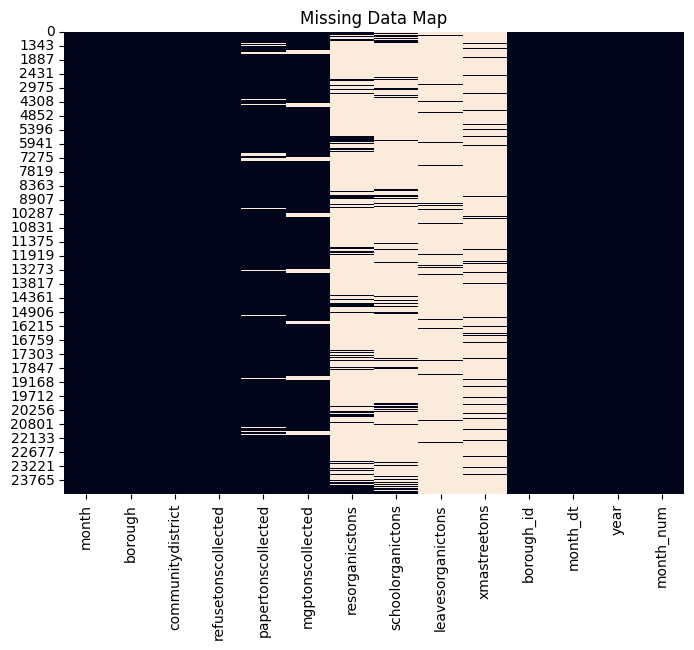

In [163]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Data Map")
plt.show()

In [164]:
df.drop(['communitydistrict' , 'borough_id'], axis=1, inplace=True) # drop columns which don't show unnecessary information for this project

**Handling missing values**

In [165]:
mode_val_refuse = df['refusetonscollected'].mode()[0]
median_mgptons = df['mgptonscollected'].median()
median_papertons = df['papertonscollected'].median()

# fill missing values with mode as only 6 values missing
df['refusetonscollected'] = df['refusetonscollected'].fillna(mode_val_refuse)

# fill missing values with median as many values missing but wish to avoid a skew due to the large standard deviation
df['mgptonscollected'] = df['mgptonscollected'].fillna(median_mgptons)
df['papertonscollected'] = df['papertonscollected'].fillna(median_papertons)

# As significant missing values, missing values likely mean there was no collection so will fill missing values with value zero
df['leavesorganictons'] = df['leavesorganictons'].fillna(0)
df['xmastreetons'] = df['xmastreetons'].fillna(0)
df['schoolorganictons'] = df['schoolorganictons'].fillna(0)
df['resorganicstons'] = df['resorganicstons'].fillna(0)

In [166]:
missing = df.isna().sum().sort_values(ascending=False)
print(missing)

month                  0
borough                0
refusetonscollected    0
papertonscollected     0
mgptonscollected       0
resorganicstons        0
schoolorganictons      0
leavesorganictons      0
xmastreetons           0
month_dt               0
year                   0
month_num              0
dtype: int64


In [167]:
# Define waste columns
waste_cols = [
    'refusetonscollected', 'papertonscollected', 'mgptonscollected',
    'resorganicstons', 'schoolorganictons', 'leavesorganictons',
    'xmastreetons'
]

In [168]:
# Replace borough-specific monthly tonnages with the NYC mean monthly tonnage for each waste category
city_monthly = (
    df
    .groupby('month_dt')[waste_cols]
    .mean()
    .reset_index()
)

In [169]:
city_monthly['month'] = city_monthly['month_dt'].dt.to_period('M') # Convert the 'month_dt' column to a Period

city_monthly = city_monthly.drop(columns=['month_dt']) # drop 'month_dt' columns as all is now in 'month' column

city_monthly = city_monthly[['month'] + waste_cols]

In [170]:
print (city_monthly.head())

     month  refusetonscollected  papertonscollected  mgptonscollected  \
0  2000-01          3256.735593          404.688136        390.144068   
1  2000-02          3207.325424          423.564407        372.291525   
2  2000-03          3555.645763          463.347458        420.154237   
3  2000-04          3485.172881          454.023729        404.893220   
4  2000-05          4110.622034          469.720339        439.635593   

   resorganicstons  schoolorganictons  leavesorganictons  xmastreetons  
0              0.0                0.0           0.000000     38.711864  
1              0.0                0.0           0.000000      0.000000  
2              0.0                0.0           0.000000      0.000000  
3              0.0                0.0           0.000000      0.000000  
4              0.0                0.0          22.532203      0.000000  


**Adding NYC Population data**

In [171]:
pop = pd.read_csv("New-York-City-Population-Total-Population-By-Year-2025-05-26-16-34.csv") #Adding the population Data
pop = pop.rename(columns={'Unnamed: 0': 'Year', 'Population': 'Population'})


In [172]:
city_monthly['Year'] = city_monthly['month'].dt.year # create a 'Year' column to merge the population data and the monthly waste data
city_monthly = city_monthly.merge(pop, on='Year', how='left')

city_monthly = city_monthly.drop(columns=['Year']) # drop the 'Year' column once data is merged

city_monthly = city_monthly[['month'] + waste_cols + ['Population']] # add 'Population' column at the end

city_monthly = city_monthly.sort_values('month') # order in chronological order

In [173]:
print(city_monthly.head())

     month  refusetonscollected  papertonscollected  mgptonscollected  \
0  2000-01          3256.735593          404.688136        390.144068   
1  2000-02          3207.325424          423.564407        372.291525   
2  2000-03          3555.645763          463.347458        420.154237   
3  2000-04          3485.172881          454.023729        404.893220   
4  2000-05          4110.622034          469.720339        439.635593   

   resorganicstons  schoolorganictons  leavesorganictons  xmastreetons  \
0              0.0                0.0           0.000000     38.711864   
1              0.0                0.0           0.000000      0.000000   
2              0.0                0.0           0.000000      0.000000   
3              0.0                0.0           0.000000      0.000000   
4              0.0                0.0          22.532203      0.000000   

   Population  
0    17813000  
1    17813000  
2    17813000  
3    17813000  
4    17813000  


In [174]:
city_monthly.describe()

,refusetonscollected,papertonscollected,mgptonscollected,resorganicstons,schoolorganictons,leavesorganictons,xmastreetons,Population
count,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,3.040000e+02
mean,3706.174852,426.956550,370.647879,10.936165,6.012086,5.821590,1.966469,1.845709e+07
std,380.419268,59.156880,59.182213,18.861084,11.299727,29.546756,7.113877,3.696506e+05
min,886.762712,96.920339,98.586441,0.000000,0.000000,0.000000,0.000000,1.781300e+07
25%,3529.922034,386.804661,327.370763,0.000000,0.000000,0.000000,0.000000,1.814200e+07
50%,3691.281356,417.869492,357.294068,0.000000,0.000000,0.000000,0.000000,1.847800e+07
75%,3920.296186,464.222034,411.322458,14.044492,9.265678,0.000000,0.000000,1.880425e+07
max,4657.688136,631.306780,561.562712,109.135593,61.915254,264.179661,40.664407,1.915400e+07


In [175]:
print(city_monthly.shape)

(304, 9)


**Further EDA**

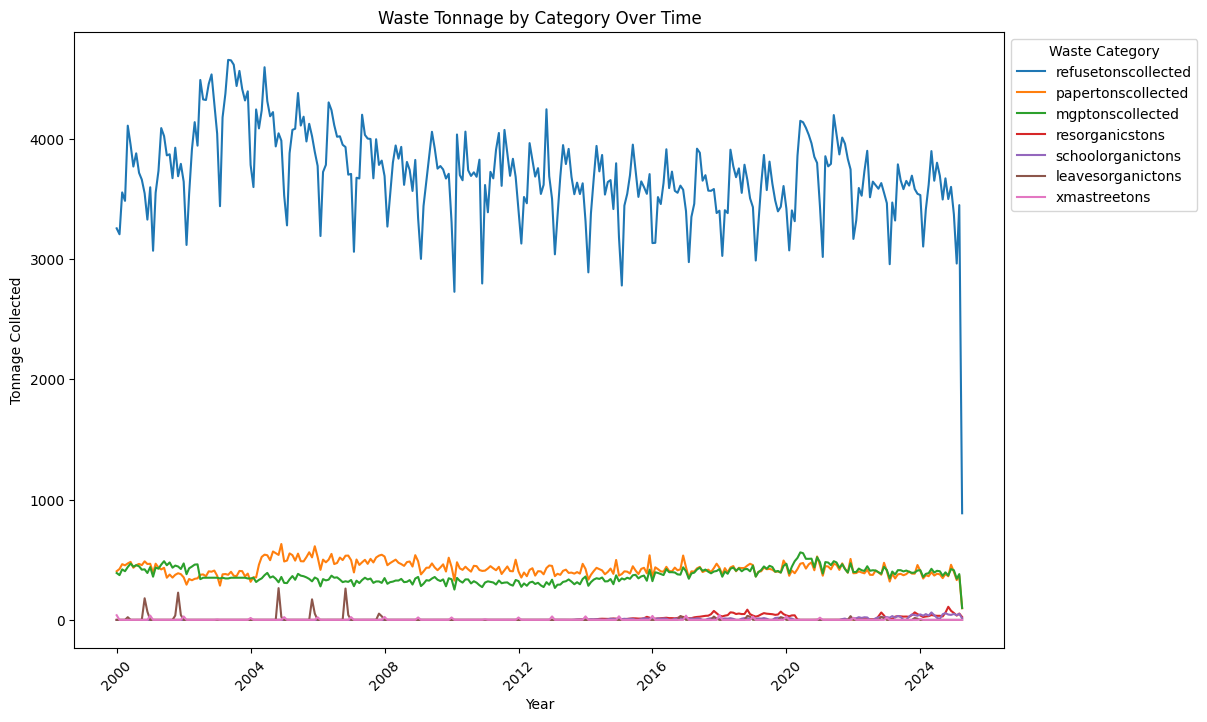

In [176]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
city_monthly['month_plot'] = city_monthly['month'].dt.to_timestamp()
plt.figure(figsize=(12, 8))
for col in waste_cols:
    sns.lineplot(data=city_monthly, x='month_plot', y=col, label=col)

plt.title('Waste Tonnage by Category Over Time')
plt.xlabel('Year')
plt.ylabel('Tonnage Collected')
plt.xticks(rotation=45)
plt.legend(title='Waste Category', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


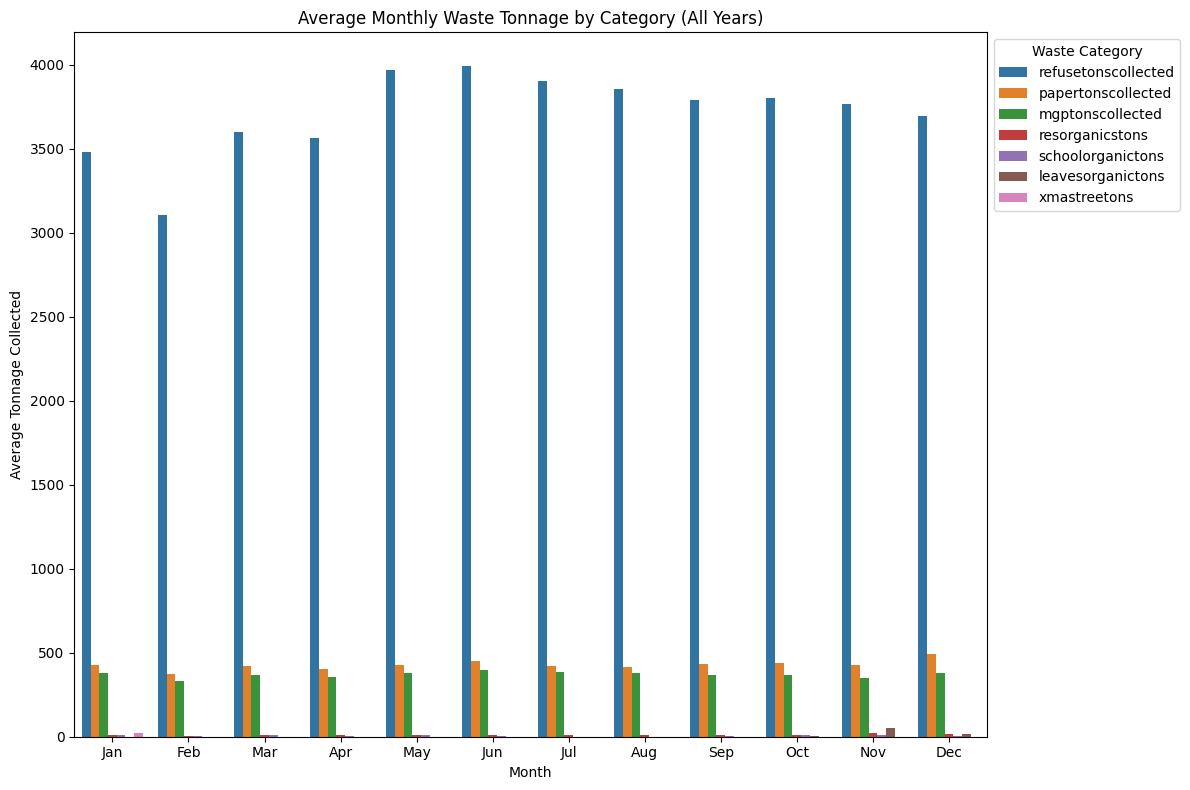

In [177]:
waste_monthly_avg = (
    df
    .groupby('month_num')[waste_cols]
    .mean()
    .reset_index()
)

waste_monthly_avg_melted = waste_monthly_avg.melt(
    id_vars='month_num',
    value_vars=waste_cols,
    var_name='Waste_Category',
    value_name='Average_Tons'
)

plt.figure(figsize=(12, 8))
sns.barplot(data=waste_monthly_avg_melted, x='month_num', y='Average_Tons', hue='Waste_Category')
plt.title('Average Monthly Waste Tonnage by Category (All Years)')
plt.xlabel('Month')
plt.ylabel('Average Tonnage Collected')
plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],)
plt.legend(title='Waste Category', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

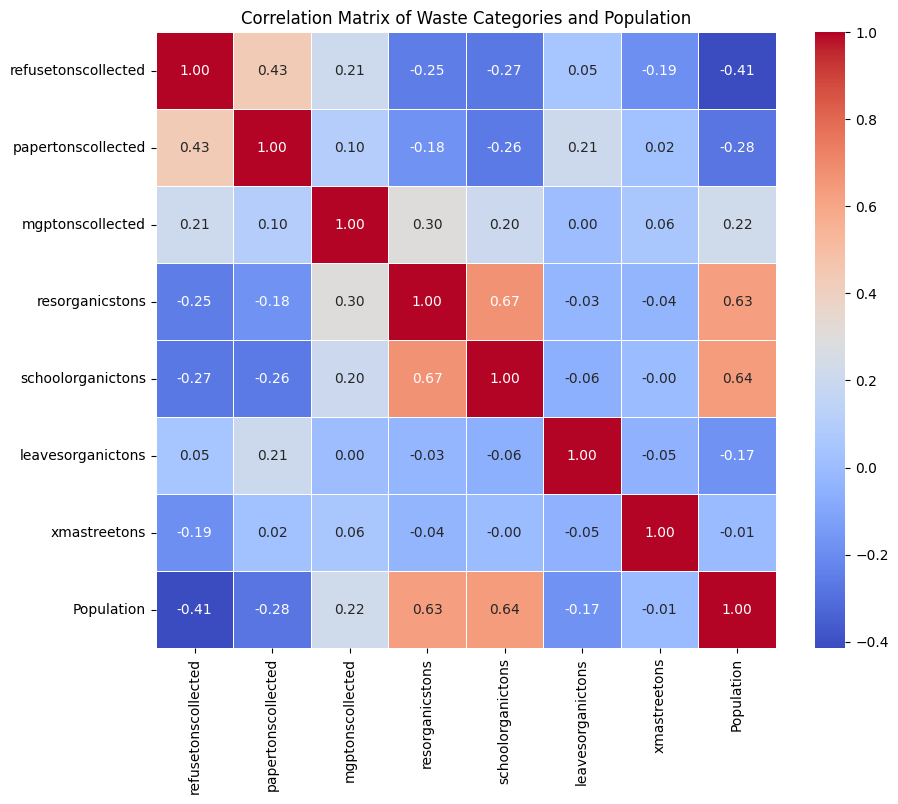

In [178]:
correlation_data = city_monthly[waste_cols + ['Population']]
correlation_matrix = correlation_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Waste Categories and Population')
plt.show()

**Machine Learning**

In [179]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
import numpy as np
import matplotlib.pyplot as plt

In [180]:
city_monthly['total_tonnage'] = city_monthly[waste_cols].sum(axis=1) # create a 'total_tonnage' varibale to sum up all waste categories

# drop target variable and the additional variable created for visualisations
columns_to_drop = [
    'total_tonnage',
    'month_plot'
]

X = city_monthly.drop(columns=columns_to_drop, axis=1) # features
y = city_monthly['total_tonnage'] # target

In [181]:
# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [182]:
numeric_cols = X.select_dtypes(include=['int64','float64']).columns
categorical_cols = X.select_dtypes(include=['object','category']).columns

In [183]:
scaler = RobustScaler() # scaling of numeric feautres to reduce effect of outliers
X_train_numeric = scaler.fit_transform(X_train[numeric_cols])
X_test_numeric  = scaler.transform(X_test[numeric_cols])

In [184]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # one hot encoding for categorical features
X_train_categorical = encoder.fit_transform(X_train[categorical_cols])
X_test_categorical  = encoder.transform(X_test[categorical_cols])

In [185]:
# Combine the processed features
X_train_processed = np.hstack([X_train_numeric, X_train_categorical])
X_test_processed = np.hstack([X_test_numeric,  X_test_categorical])

**Linear Regression**

In [186]:
# Initialise and train the model
lr = LinearRegression()
lr.fit(X_train_processed, y_train)

LinearRegression()

In [187]:
# Predict y when given the test set (X_test)
y_pred_lr = lr.predict(X_test_processed)

In [188]:
# Evaluation metrics for Linear Regression
print("MSE:", mean_squared_error(y_test, y_pred_lr))
print("R²:",  r2_score(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("MAE:", mean_absolute_error(y_test, y_pred_lr))

MSE: 5.7800940344381645e-24
R²: 1.0
RMSE: 2.404182612539689e-12
MAE: 1.0362275700527625e-12


In [189]:
np.set_printoptions(precision=2)
print(np.concatenate((y_pred_lr.reshape(len(y_pred_lr),1), y_test.values.reshape(len(y_test),1)),1))

[[3915.62 3915.62]
 [4992.61 4992.61]
 [4412.57 4412.57]
 [5027.59 5027.59]
 [4347.36 4347.36]
 [4535.66 4535.66]
 [4574.02 4574.02]
 [3670.55 3670.55]
 [4443.4  4443.4 ]
 [5211.92 5211.92]
 [4901.78 4901.78]
 [4638.51 4638.51]
 [5172.18 5172.18]
 [4375.35 4375.35]
 [4353.01 4353.01]
 [5033.36 5033.36]
 [4840.29 4840.29]
 [3987.45 3987.45]
 [4424.7  4424.7 ]
 [4517.24 4517.24]
 [3746.94 3746.94]
 [4297.72 4297.72]
 [4801.38 4801.38]
 [3791.77 3791.77]
 [4112.7  4112.7 ]
 [4724.18 4724.18]
 [4693.21 4693.21]
 [3887.77 3887.77]
 [4818.58 4818.58]
 [3662.43 3662.43]
 [4639.82 4639.82]
 [4556.83 4556.83]
 [4796.51 4796.51]
 [5335.34 5335.34]
 [4945.75 4945.75]
 [4645.02 4645.02]
 [5139.74 5139.74]
 [4805.73 4805.73]
 [4496.75 4496.75]
 [4835.37 4835.37]
 [4458.61 4458.61]
 [5156.35 5156.35]
 [4417.06 4417.06]
 [4534.36 4534.36]
 [4790.41 4790.41]
 [4444.25 4444.25]
 [4384.51 4384.51]
 [4930.35 4930.35]
 [4491.61 4491.61]
 [4482.17 4482.17]
 [3771.79 3771.79]
 [4668.46 4668.46]
 [4978.83 49

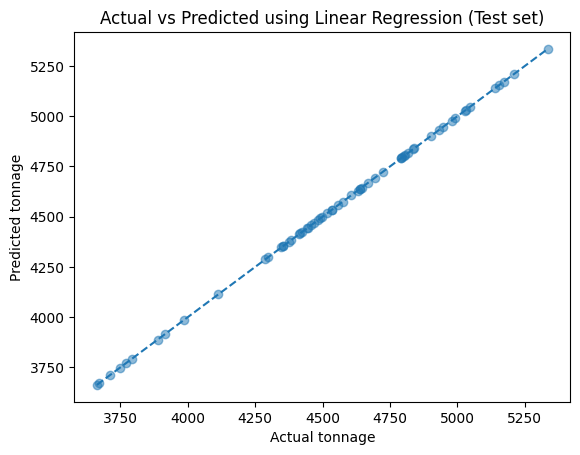

In [190]:
# Scatter plot to visualize the actual vs. predicted values
plt.figure()
plt.scatter(y_test, y_pred_lr, alpha=0.5)

min_val = min(y_test.min(), y_pred_lr.min())
max_val = max(y_test.max(), y_pred_lr.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--')
plt.xlabel('Actual tonnage')
plt.ylabel('Predicted tonnage')
plt.title('Actual vs Predicted using Linear Regression (Test set)')
plt.show()


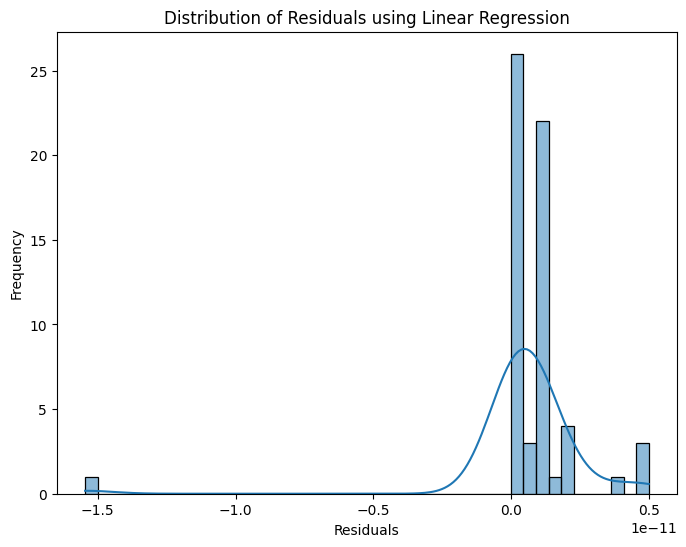

In [191]:
# Residuals Distribution Plot for Linear Regression
residuals = y_test - y_pred_lr
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals using Linear Regression')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [192]:
# Cross-Validation for Linear Regression
cv_scores_lr = cross_val_score(lr, X_train_processed, y_train, cv=5, scoring='r2')
print("Linear Regression CV R² Scores:", cv_scores_lr)

Linear Regression CV R² Scores: [1. 1. 1. 1. 1.]


**Random Forest**

In [193]:
# Initialize and train the model
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_processed, y_train)

RandomForestRegressor(random_state=42)

In [194]:
# Grid of hyperparameter tunning for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 150, 200, 500, 1000],
    'max_depth': [None, 10, 15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2']
}
# RandomizedSearchCV to find the best hyperparameter
grid_search_rf = RandomizedSearchCV(estimator=rf,
                              param_distributions=param_grid_rf,
                              cv=5,
                              scoring='r2',
                              n_jobs=-1)

grid_search_rf.fit(X_train_processed, y_train) # fit on the training data to find best parameters

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 15, 20, 25],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 5, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 150, 200, 500,
                                                         1000]},
                   scoring='r2')

In [195]:
print("Best hyperparameters for Random Forest:", grid_search_rf.best_params_)
print("Best cross-validation R² score:", grid_search_rf.best_score_)
best_rf_model = grid_search_rf.best_estimator_

Best hyperparameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Best cross-validation R² score: 0.8805491249977461


In [196]:
# Evaluation Metrics for Random Forest
y_pred_best_rf = best_rf_model.predict(X_test_processed)
test_mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
test_r2_best_rf = r2_score(y_test, y_pred_best_rf)
test_rmse_best_rf = np.sqrt(test_mse_best_rf)
test_mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)

print("Test MSE:", test_mse_best_rf)
print("Test R²:",  test_r2_best_rf)
print("Test RMSE:", test_rmse_best_rf)
print("Test MAE:", test_mae_best_rf)

Test MSE: 4343.877543143543
Test R²: 0.9739299490625837
Test RMSE: 65.90809922265657
Test MAE: 46.739666232674566


In [197]:
y_pred_rf = rf.predict(X_test_processed)
print(np.concatenate((y_pred_best_rf.reshape(len(y_pred_best_rf),1), y_test.values.reshape(len(y_test),1)),1))

[[3914.4  3915.62]
 [4801.67 4992.61]
 [4448.44 4412.57]
 [4953.95 5027.59]
 [4364.9  4347.36]
 [4504.3  4535.66]
 [4585.65 4574.02]
 [3702.92 3670.55]
 [4460.34 4443.4 ]
 [5161.5  5211.92]
 [4815.84 4901.78]
 [4641.09 4638.51]
 [5159.64 5172.18]
 [4402.63 4375.35]
 [4194.56 4353.01]
 [5077.92 5033.36]
 [4801.11 4840.29]
 [3993.85 3987.45]
 [4372.78 4424.7 ]
 [4523.1  4517.24]
 [3807.66 3746.94]
 [4315.57 4297.72]
 [4777.36 4801.38]
 [3954.79 3791.77]
 [4087.17 4112.7 ]
 [4696.44 4724.18]
 [4699.82 4693.21]
 [3905.72 3887.77]
 [4754.46 4818.58]
 [3726.32 3662.43]
 [4664.81 4639.82]
 [4503.41 4556.83]
 [4772.86 4796.51]
 [5267.45 5335.34]
 [4899.01 4945.75]
 [4610.85 4645.02]
 [5000.2  5139.74]
 [4842.1  4805.73]
 [4494.94 4496.75]
 [4887.34 4835.37]
 [4467.52 4458.61]
 [5092.03 5156.35]
 [4439.57 4417.06]
 [4557.15 4534.36]
 [4741.72 4790.41]
 [4375.99 4444.25]
 [4418.5  4384.51]
 [4924.15 4930.35]
 [4474.59 4491.61]
 [4538.39 4482.17]
 [3894.78 3771.79]
 [4699.62 4668.46]
 [4987.17 49

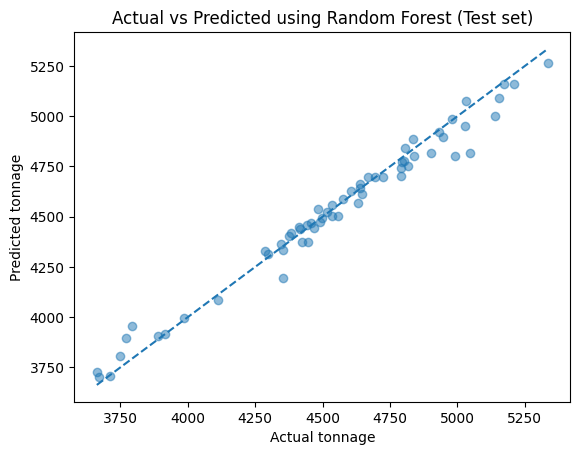

In [198]:
# Scatter plot to visualize the actual vs. predicted values in Random Forest
plt.figure()
plt.scatter(y_test, y_pred_best_rf, alpha=0.5)
min_val = min(y_test.min(), y_pred_best_rf.min())
max_val = max(y_test.max(), y_pred_best_rf.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--')
plt.xlabel('Actual tonnage')
plt.ylabel('Predicted tonnage')
plt.title('Actual vs Predicted using Random Forest (Test set)')
plt.show()

In [199]:
# Cross-Validation for Random Forest
cv_scores_rf = cross_val_score(rf, X_train_processed, y_train, cv=5, scoring='r2')
print("Random Forest CV R² Scores:", cv_scores_rf)

Random Forest CV R² Scores: [0.95 0.97 0.96 0.98 0.68]


<ipython-input-200-0b02576d1d77>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


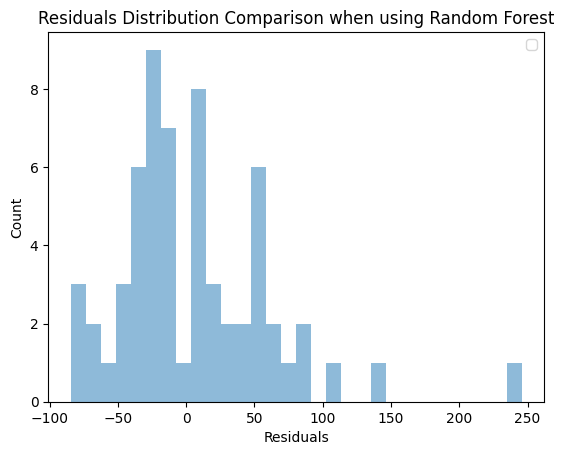

In [200]:
# Residuals Distribution Plot for Random Forest
resid_rf = y_test - y_pred_rf

plt.figure()
plt.hist(resid_rf, bins=30, alpha=0.5)
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.title('Residuals Distribution Comparison when using Random Forest')
plt.legend()
plt.show()


**XG Boosting**

In [201]:
!pip install xgboost
from xgboost import XGBRegressor

In [202]:
xgb = XGBRegressor(random_state=42) # Initialise XGBRegressor model

In [203]:
# Hyperparameter tunning for XG Boosting
param_grid = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'max_depth': [None, 10, 15, 20, 25],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5]
}
# RandomizedSearchCV to find the best parameter grid
grid_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    cv=5, # 5 fold cross validation
    scoring='r2', # Using R² as the evaluation metric
    n_jobs=-1,
    verbose=1
)
grid_search_xgb.fit(X_train_processed, y_train) # fit hyperparameter on the grid found

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 1, 5],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [None, 10, 15, 20, 25],
                                        'n_estimators': [50, 100, 200, 500,
                                                         1000],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='r2', verbose=1)

In [204]:
print("Best hyperparameters for XGB:", grid_search_xgb.best_params_)
print("Best cross-validation R² score:", grid_search_xgb.best_score_)
best_xgb_model = grid_search_xgb.best_estimator_

Best hyperparameters for XGB: {'subsample': 0.6, 'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.2, 'gamma': 5, 'colsample_bytree': 1.0}
Best cross-validation R² score: 0.9302657883612973


In [205]:
y_pred_best_xgb = best_xgb_model.predict(X_test_processed) # predict on the test set using the tuned XGBoost model

In [206]:
# XGB Evaluation Metrics
test_mse_best_xgb = mean_squared_error(y_test, y_pred_best_xgb)
test_r2_best_xgb = r2_score(y_test, y_pred_best_xgb)
test_rmse_best_xgb = np.sqrt(test_mse_best_xgb)
test_mae_best_xgb = mean_absolute_error(y_test, y_pred_best_xgb)

print("Test MSE:", test_mse_best_xgb)
print("Test R²:",  test_r2_best_xgb)
print("Test RMSE:", test_rmse_best_xgb)
print("Test MAE:", test_mae_best_xgb)

Test MSE: 1868.9583636765824
Test R²: 0.9887833302718523
Test RMSE: 43.23145109381112
Test MAE: 36.19305880865343


In [207]:

print(np.concatenate((y_pred_best_xgb.reshape(len(y_pred_best_xgb),1), y_test.values.reshape(len(y_test),1)),1))

[[3986.64 3915.62]
 [4974.51 4992.61]
 [4406.39 4412.57]
 [5029.62 5027.59]
 [4296.98 4347.36]
 [4483.   4535.66]
 [4638.25 4574.02]
 [3713.82 3670.55]
 [4480.   4443.4 ]
 [5180.08 5211.92]
 [4842.39 4901.78]
 [4597.8  4638.51]
 [5139.56 5172.18]
 [4394.77 4375.35]
 [4320.62 4353.01]
 [5058.75 5033.36]
 [4857.54 4840.29]
 [3902.01 3987.45]
 [4373.04 4424.7 ]
 [4544.1  4517.24]
 [3726.54 3746.94]
 [4329.62 4297.72]
 [4788.04 4801.38]
 [3797.56 3791.77]
 [4196.44 4112.7 ]
 [4688.69 4724.18]
 [4707.04 4693.21]
 [3933.37 3887.77]
 [4773.54 4818.58]
 [3650.35 3662.43]
 [4688.73 4639.82]
 [4538.18 4556.83]
 [4831.92 4796.51]
 [5411.17 5335.34]
 [4895.83 4945.75]
 [4639.01 4645.02]
 [5104.96 5139.74]
 [4822.49 4805.73]
 [4529.86 4496.75]
 [4865.75 4835.37]
 [4499.26 4458.61]
 [5211.01 5156.35]
 [4473.29 4417.06]
 [4546.52 4534.36]
 [4793.99 4790.41]
 [4351.6  4444.25]
 [4420.55 4384.51]
 [4935.76 4930.35]
 [4461.74 4491.61]
 [4519.62 4482.17]
 [3718.14 3771.79]
 [4711.66 4668.46]
 [5040.93 49

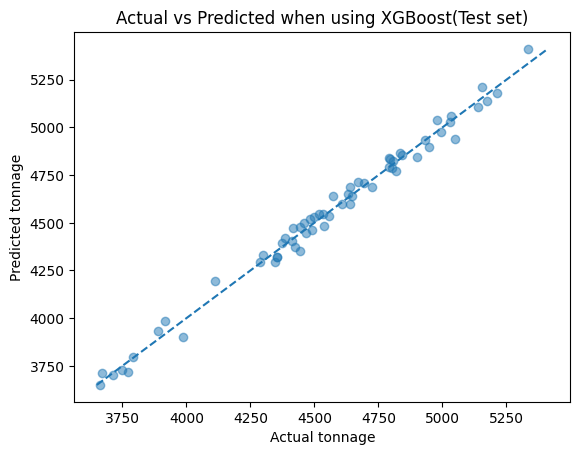

In [208]:
# Scatter plot for the XGBoost model's predictions (Actual vs. Predicted)
plt.figure()
plt.scatter(y_test, y_pred_best_xgb, alpha=0.5)
min_val = min(y_test.min(), y_pred_best_xgb.min())
max_val = max(y_test.max(), y_pred_best_xgb.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--')
plt.xlabel('Actual tonnage')
plt.ylabel('Predicted tonnage')
plt.title('Actual vs Predicted when using XGBoost(Test set)')
plt.show()

<ipython-input-209-65dca589f4e2>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


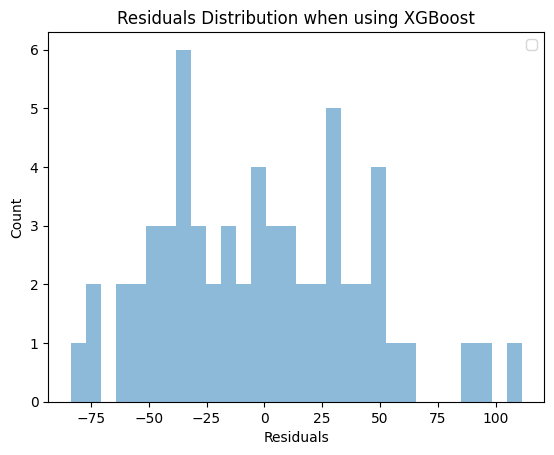

In [209]:
# Residuals Distribution Plot for XG Boost
resid_xgb = y_test - y_pred_best_xgb

plt.figure()
plt.hist(resid_xgb, bins=30, alpha=0.5)
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.title('Residuals Distribution when using XGBoost')
plt.legend()
plt.show()

In [210]:
# Cross-Validation for XG Boost
cv_scores_xgb = cross_val_score(xgb, X_train_processed, y_train, cv=5, scoring='r2')
print("XGB CV R² Scores:", cv_scores_xgb)

XGB CV R² Scores: [0.95 0.97 0.99 0.98 0.72]


**Comparison of** **Models**

In [211]:
# Model Performance Comparison Table
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

mse_rf = mean_squared_error(y_test, y_pred_best_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_best_rf)
r2_rf = r2_score(y_test, y_pred_best_rf)

mse_xgb = mean_squared_error(y_test, y_pred_best_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_best_xgb)
r2_xgb = r2_score(y_test, y_pred_best_xgb)

results = pd.DataFrame({
    'Model': ['LinearRegression', 'RandomForest', "XGBoost"],
    'Test MSE': [mse_lr, mse_rf, mse_xgb],
    'Test RMSE': [rmse_lr, rmse_rf, rmse_xgb],
    'Test MAE': [mae_lr, mae_rf, mae_xgb],
    'Test R²': [r2_lr, r2_rf, r2_xgb]
})
print(results)

              Model      Test MSE     Test RMSE      Test MAE   Test R²
0  LinearRegression  5.780094e-24  2.404183e-12  1.036228e-12  1.000000
1      RandomForest  4.343878e+03  6.590810e+01  4.673967e+01  0.973930
2           XGBoost  1.868958e+03  4.323145e+01  3.619306e+01  0.988783


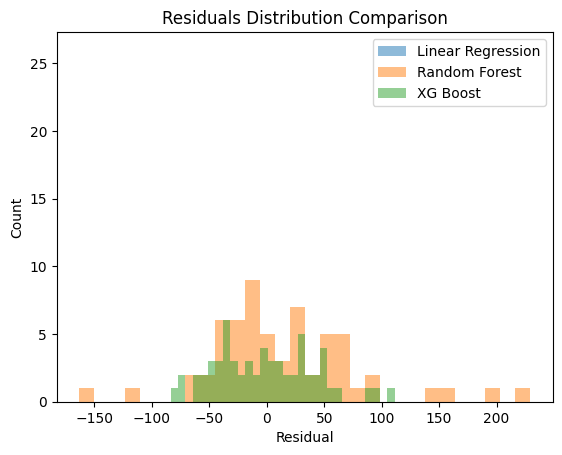

In [212]:
# Combined Residuals Distribution Plot
resid_lr = y_test - y_pred_lr
resid_rf = y_test - y_pred_best_rf
resid_xgb = y_test - y_pred_best_xgb
plt.figure()
plt.hist(resid_lr, bins=30, alpha=0.5, label='Linear Regression')
plt.hist(resid_rf, bins=30, alpha=0.5, label='Random Forest')
plt.hist(resid_xgb, bins=30, alpha=0.5, label='XG Boost')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.title('Residuals Distribution Comparison')
plt.legend()
plt.show()